https://wandb.ai/ml43d/3dpart-simclr/runs/21070614442839/files/3dpart-simclr/21070614442839/checkpoints

In [1]:
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 
os.chdir('..')

In [2]:
import time
import torch
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader

%matplotlib inline
import matplotlib.pyplot as plt

from datasets.shapenet_parts.shapenet_parts import ShapeNetParts
from datasets.data_modules import PartSegmentationDataModule

from models.pointnet import PointNetSegmentation
from pointnet_module import SupervisedPointNet
from simclr_module import SimCLR

/home/shepherd/anaconda3/lib/python3.7/site-packages/pl_bolts/utils/warnings.py:32: UserWarning: You want to use `wandb` which is not installed yet, install it with `pip install wandb`.
  f' install it with `pip install {pypi_name}`.' + extra_text
/home/shepherd/anaconda3/lib/python3.7/site-packages/pl_bolts/utils/warnings.py:32: UserWarning: You want to use `gym` which is not installed yet, install it with `pip install gym`.
  f' install it with `pip install {pypi_name}`.' + extra_text


Load the model with saved weights

In [3]:
batch_size = 8
#limit_ratio = 0.8

#dm = PartSegmentationDataModule(batch_size,limit_ratio=limit_ratio)
dm = PartSegmentationDataModule(batch_size)
seg_class_map = dm.seg_class_map
num_seg_classes = dm.num_seg_classes
num_classes = dm.num_classes

#train_dataloader = dm.train_dataloader()
test_dataloader = dm.test_dataloader()
plmodel = SupervisedPointNet(gpus=1,batch_size=batch_size,seg_class_map=seg_class_map)
plmodel = plmodel.load_from_checkpoint(checkpoint_path="./checkpoints/supervised_no_aug_best_21071320395666.ckpt")

ss_simclr_model = SimCLR(gpus=1,
                         batch_size=batch_size,
                         dataset='shapenet',
                         num_samples = len(test_dataloader)*batch_size)
ss_simclr_model = ss_simclr_model.load_from_checkpoint(checkpoint_path="./checkpoints/simclr_best_21071416584428.ckpt")

In [7]:
def get_latent_space_and_label(plmodel,data_loader,batch_size=8,save_suffix='',quick_load=True,file_to_load=None,ss=False):
    num_features = 2048
    z_y = np.zeros((len(data_loader)*batch_size,num_features+1))
    
    if not quick_load or file_to_load==None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        plmodel = plmodel.to(device)
        plmodel.eval()
        if ss:
            encoder = plmodel.encoder
        else:
            encoder = plmodel.model.encoder
        with torch.no_grad():
            i = 0
            for batch_index,batch in enumerate(data_loader):
                x,_,cls_id = batch
                x = x.to(device)
                cls_id = cls_id.to(device)
                out_max,concat,trans_feat = encoder(x)
                end = i + batch_size
                z_y[i:end] = torch.cat((out_max.detach().cpu(),cls_id.detach().cpu().unsqueeze(1)),1)
                i = end
        print(z_y.shape)
        with open('z_y_{}.npy'.format(save_suffix), 'wb') as f:
            np.save(f, z_y)
    else:
        z_y = np.load(file_to_load)
    return z_y

In [5]:
import seaborn as sns
def tsne(x,y,n_iter = 5000,perplexity=50,plot_save_suffix=''):
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=0, perplexity=perplexity, n_iter=n_iter)
    tsne_results = tsne.fit_transform(x)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

    if not os.path.isdir('plots'):
        os.makedirs('plots')
    
    plt.figure(figsize=(16,10))
    tsne_plot = sns.scatterplot(
        x=tsne_results[:,0], y=tsne_results[:,1],
        hue=y,
        palette=sns.color_palette("hls", num_classes),
        legend="full",
        alpha=0.3
    )
    tsne_plot.figure.savefig('plots/tsne_{}i_{}p_{}.png'.format(n_iter,perplexity,plot_save_suffix))

In [10]:
z_y = get_latent_space_and_label(plmodel,
                       test_dataloader,
                       batch_size=batch_size,
                       save_suffix='supervised_best_on_testset',
                       file_to_load='z_y_supervised.npy')
x = z_y[:,:-1]
y = z_y[:,-1]

Lets now first apply PCA to decrease the number of dimensions before applying t-SNE.
And we get ~91 percent explained variation in the data. It is a pretty good explanation of the data. Let's apply t-SNE to this data alongside to original data to see what we can get.

Perplexity: 50, Number of Iterations: 5000 ...
t-SNE done! Time elapsed: 857.6158132553101 seconds


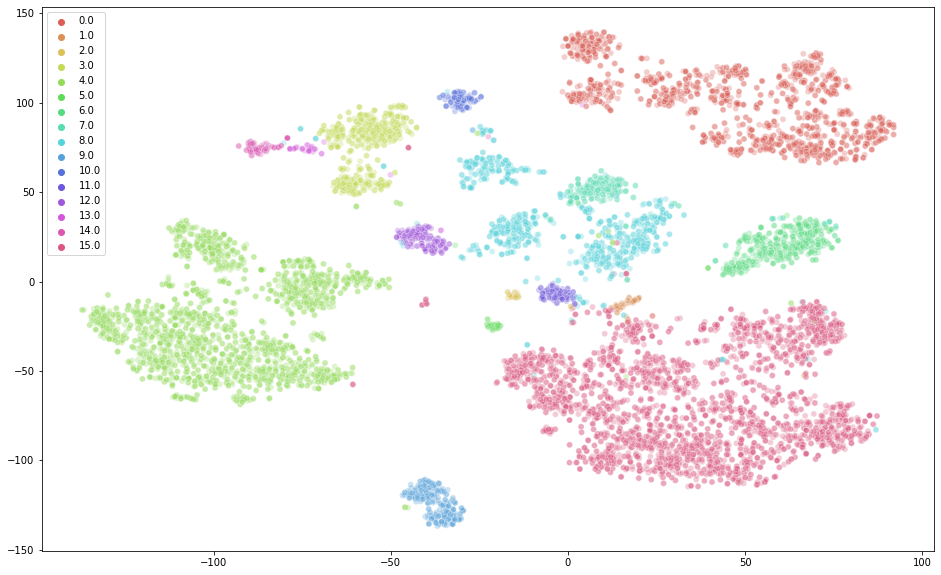

In [11]:
#pca_50 = PCA(n_components=50)
#pca_result_50 = pca_50.fit_transform(x)
#print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

n_iters = [5000]
perplexities = [50]
for n_iter in n_iters:
    for perplexity in perplexities:
        print('Perplexity: {}, Number of Iterations: {} ...'.format(perplexity,n_iter))
        tsne(x,y,n_iter=n_iter,perplexity=perplexity, plot_save_suffix='supervised_best_on_testset')
        #tsne(pca_result_50,y,n_iter=n_iter,perplexity=perplexity, plot_save_suffix='supervised_pca_applied')

In [8]:
# Self Supervised
z_y_ss = get_latent_space_and_label(ss_simclr_model,
                       test_dataloader,
                       batch_size=batch_size,
                       save_suffix='self_supervised_best_on_testset',
                       file_to_load='z_y_self_supervised.npy',
                                    quick_load=False,
                                    ss=True)

x_ss = z_y_ss[:,:-1]
y_ss = z_y_ss[:,-1]

(2872, 2049)


Perplexity: 50, Number of Iterations: 5000 ...
t-SNE done! Time elapsed: 150.73733186721802 seconds


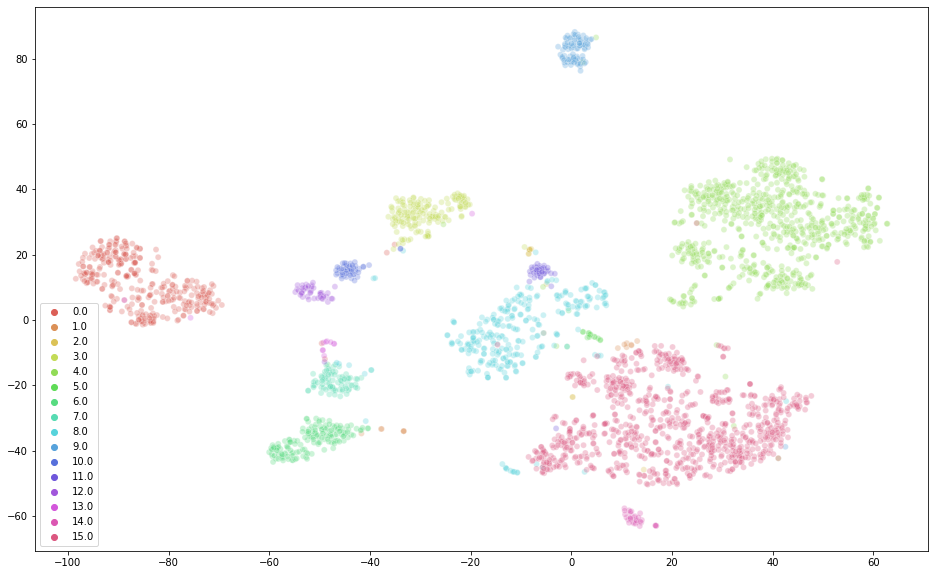

In [9]:
#pca_50_ss = PCA(n_components=50)
#pca_result_50_ss = pca_50_ss.fit_transform(x_ss)
#print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50_ss.explained_variance_ratio_)))

n_iters = [5000]
perplexities = [50]
for n_iter in n_iters:
    for perplexity in perplexities:
        print('Perplexity: {}, Number of Iterations: {} ...'.format(perplexity,n_iter))
        tsne(x_ss,y_ss,n_iter=n_iter,perplexity=perplexity, plot_save_suffix='ss_best_on_testset')
        #tsne(pca_result_50_ss,y_ss,n_iter=n_iter,perplexity=perplexity, plot_save_suffix='ss_2676_epoch_0_pca_applied')